In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../qbiome'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.style.use('ggplot')

from data_formatter import DataFormatter
from quantizer import Quantizer
from qnet_orchestrator import QnetOrchestrator
from forecaster import Forecaster

In [2]:
dirname = 'example_data/'
data = dirname + 'SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_TaxaRelativeAbundance.csv'
meta = dirname + 'SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_Characteristics.csv'

# Instantiate the data formatter, quantizer, qnet orchestrator, and forecaster

In [3]:
formatter = DataFormatter()
quantizer = Quantizer()
qnet_orchestrator = QnetOrchestrator(quantizer)
forecaster = Forecaster(qnet_orchestrator)

# Load, quantize, and convert the data to qnet input format

In [4]:
data = formatter.load_data(data, meta)
quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)

There are 29 unique biomes and 1216 unique samples
There are 311 unique days
There are 99 unique weeks


In [5]:
# how many weeks of data do we have?
# how many biome_week feature names do we have?
data.week.max(), len(features)

(98, 622)

In [6]:
data.head()

,sample_id,subject_id,variable,week,value
7,MBSMPL0020-6-10,1,Actinobacteriota,27,0.366650
8,MBSMPL0020-6-10,1,Bacteroidota,27,0.507248
9,MBSMPL0020-6-10,1,Campilobacterota,27,0.002032
10,MBSMPL0020-6-10,1,Desulfobacterota,27,0.005058
11,MBSMPL0020-6-10,1,Firmicutes,27,0.057767


In [8]:
features

Index(['Acidobacteriota_1', 'Acidobacteriota_9', 'Acidobacteriota_27',
       'Acidobacteriota_31', 'Acidobacteriota_35', 'Actinobacteriota_1',
       'Actinobacteriota_2', 'Actinobacteriota_3', 'Actinobacteriota_5',
       'Actinobacteriota_6',
       ...
       'unclassified_Bacteria_10', 'unclassified_Bacteria_22',
       'unclassified_Bacteria_27', 'unclassified_Bacteria_34',
       'unclassified_Bacteria_36', 'unclassified_Bacteria_40',
       'unclassified_Bacteria_57', 'unclassified_Bacteria_79',
       'unclassified_Bacteria_80', 'unclassified_Bacteria_88'],
      dtype='object', length=622)

In [9]:
label_matrix

array([['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', ''],
       ...,
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', ''],
       ['E', '', '', ..., '', '', '']], dtype='<U1')

# Train, save, and load the model

In [10]:
qnet_orchestrator.model

In [12]:
%%time
qnet_orchestrator.train_qnet(
    features, label_matrix, alpha=0.2, min_samples_split=2, 
    out_fname='biome_net_1.joblib')

CPU times: user 2min, sys: 1.72 s, total: 2min 2s
Wall time: 2min 28s


# Load a pre-trained qnet

In [26]:
%%time
qnet_orchestrator.load_qnet('biome_net_1.joblib')

CPU times: user 57.2 s, sys: 222 ms, total: 57.4 s
Wall time: 57.6 s


# Construct a new patient

We construct a new patient from the quantized data column names because it contains all the feature names that the qnet uses.

In [14]:
# initialize with random floats
new_patient = pd.DataFrame(
    np.random.rand(1, len(quantized.columns)),
    index=[0],
    columns=quantized.columns
)
new_patient.subject_id = '101'
new_patient

,subject_id,Acidobacteriota_1,Acidobacteriota_9,Acidobacteriota_27,Acidobacteriota_31,Acidobacteriota_35,Actinobacteriota_1,Actinobacteriota_2,Actinobacteriota_3,Actinobacteriota_5,...,unclassified_Bacteria_10,unclassified_Bacteria_22,unclassified_Bacteria_27,unclassified_Bacteria_34,unclassified_Bacteria_36,unclassified_Bacteria_40,unclassified_Bacteria_57,unclassified_Bacteria_79,unclassified_Bacteria_80,unclassified_Bacteria_88
0,101,0.469831,0.945429,0.20488,0.529128,0.069749,0.423597,0.229976,0.834395,0.997172,...,0.964706,0.66872,0.706928,0.359851,0.358159,0.420606,0.572881,0.219343,0.216838,0.140299


In [15]:
new_patient_seq = new_patient.drop(columns='subject_id').to_numpy().squeeze()
new_patient_seq.shape

(622,)

In [16]:
# suppose we only have 6 weeks of data for the new patient
# we mask out the remainder of the weeks
new_patient_masked = qnet_orchestrator.mask_sequence_at_weeks(
    new_patient_seq, 
    start_week=7, 
    end_week=qnet_orchestrator.get_max_timestamp(),
    fill_value=np.nan
)

In [17]:
new_patient_df = quantizer.add_meta_to_matrix(
    new_patient_masked[np.newaxis, :],
    add_subject_id=False
)
# manually add back subject_id
new_patient_df.insert(0, 'subject_id', ['101'])

In [18]:
new_patient_df

variable,subject_id,Acidobacteriota_1,Acidobacteriota_27,Acidobacteriota_31,Acidobacteriota_35,Acidobacteriota_9,Actinobacteriota_1,Actinobacteriota_10,Actinobacteriota_11,Actinobacteriota_13,...,unclassified_Bacteria_27,unclassified_Bacteria_34,unclassified_Bacteria_36,unclassified_Bacteria_40,unclassified_Bacteria_57,unclassified_Bacteria_6,unclassified_Bacteria_7,unclassified_Bacteria_79,unclassified_Bacteria_80,unclassified_Bacteria_88
0,101,0.469831,NaN,NaN,NaN,NaN,0.423597,0.229976,0.834395,0.997172,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
new_patient_df = quantizer.melt_into_plot_format(new_patient_df)

In [20]:
new_patient_df

,subject_id,variable,week,value
0,101,Acidobacteriota,1,0.469831
1,101,Acidobacteriota,27,NaN
2,101,Acidobacteriota,31,NaN
3,101,Acidobacteriota,35,NaN
4,101,Acidobacteriota,9,NaN
...,...,...,...,...
617,101,unclassified_Bacteria,6,NaN
618,101,unclassified_Bacteria,7,NaN
619,101,unclassified_Bacteria,79,NaN
620,101,unclassified_Bacteria,80,NaN


In [21]:
# quantize
new_patient_quantized = quantizer.quantize_df(new_patient_df)
# convert this patient into a format acceptable by the qnet
_, new_patient_matrix = quantizer.get_qnet_inputs(new_patient_quantized)

In [22]:
new_patient_matrix.shape

(1, 622)

# Forecast the data starting from `week 10` to the last week

In [23]:
# takes 2 minutes to run
forecasted = forecaster.forecast_data(
    new_patient_matrix, 
    start_week=7
)

# Inspect the forecasted data

The NaNs are due to the random values we generated falling outside the quantization range.

In [24]:
forecasted.head()

,subject_id,variable,week,value
0,101,Acidobacteriota,1,NaN
1,101,Acidobacteriota,27,0.002400
2,101,Acidobacteriota,31,0.000191
3,101,Acidobacteriota,35,0.000525
4,101,Acidobacteriota,9,0.000319


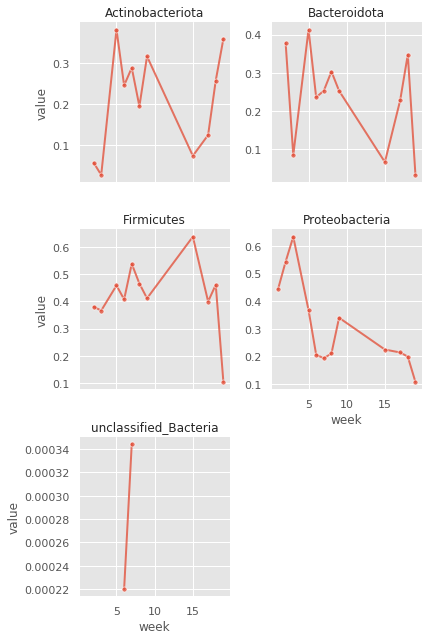

In [25]:
BIOMES = ['Actinobacteriota', 'Bacteroidota', 'Firmicutes', 'Proteobacteria', 'unclassified_Bacteria']

plottable = forecasted[
    (forecasted.variable.isin(BIOMES)) &
    (forecasted.week < 20)
     ]

g = sns.FacetGrid(plottable, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

In [27]:
# takes 2 minutes to run
forecasted = forecaster.forecast_data(
    new_patient_matrix, 
    start_week=7
)

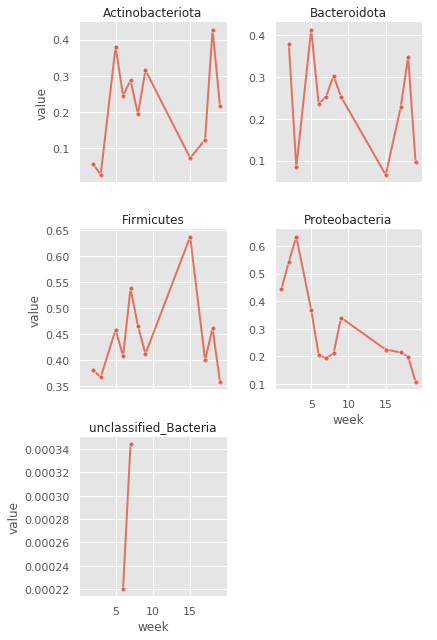

In [28]:
BIOMES = ['Actinobacteriota', 'Bacteroidota', 'Firmicutes', 'Proteobacteria', 'unclassified_Bacteria']

plottable = forecasted[
    (forecasted.variable.isin(BIOMES)) &
    (forecasted.week < 20)
     ]

g = sns.FacetGrid(plottable, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()